In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path

from scipy.stats import  mannwhitneyu, ks_2samp

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "10k_heart"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 

  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pt_S_v_S_tilde = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  df_top_2K = df_analy[ df_analy['rank_stat'] <= 2000 ]     
  x_cut = pd.qcut ( df_top_2K['nz_cells'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  y_cut = pd.qcut ( df_top_2K['abs_log_ratio'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  df_top_2K = df_top_2K.assign( Q_nz_cells = x_cut[0] )  
  df_top_2K = df_top_2K.assign( Q_instability = y_cut[0] )    
  pt = pv_table_noprint_margins ( df_top_2K, 'Q_instability', 'Q_nz_cells' )  
  pt_instability_v_nz_cells = ( pt.transpose() [[ 'Q4','Q3','Q2','Q1', 'Total']] ).transpose()
    
    
  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] <= 200 ].min()  
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
    
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label,  method_symbol.lower()  + ': instability' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 

  plot_ax ( df_analy, ax3, 'C', 'nz_cells', 'abs_log_ratio',  "$n_g$: nonzero cells" , method_symbol.lower()  + ': instability' ,yscale_log=False, line_slope='none' )
  

  y_min2, y_max2 = ax2.get_ylim()
  y_min3, y_max3 = ax3.get_ylim()
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max )    
  

  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return ( pt_S_v_S_tilde, pt_instability_v_nz_cells,  df_top_2K['abs_log_ratio'].values )

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_nz_cells = nru_dict['df_gene_stats'] [['nz_cells']]
print (  '\n\n df_nz_cells: ' )  
print (  '\n', df_nz_cells   )  


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
df_A_g['rank_stat'] = df_A_g['stat'].rank( ascending=False )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
df_L_g['rank_stat'] = df_L_g['stat'].rank( ascending=False )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
df_S_g['rank_stat'] = df_S_g['stat'].rank( ascending=False )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )



 df_nz_cells: 

                     nz_cells
ENSMUSG00000052305      6202
ENSMUSG00000069919      2897
ENSMUSG00000073940      2925
ENSMUSG00000069917      2625
ENSMUSG00000038791       802
...                      ...
ENSMUSG00000020905        54
ENSMUSG00000027313        50
ENSMUSG00000104861        55
ENSMUSG00000041144        56
ENSMUSG00000000154        58

[14472 rows x 1 columns]


 df_A_g:  

                            stat  rank_stat
ENSMUSG00000052305  5431.424034        1.0
ENSMUSG00000069919  1391.789121        2.0
ENSMUSG00000073940  1383.160300        3.0
ENSMUSG00000069917   971.366465        4.0
ENSMUSG00000038791   603.920335        5.0
...                         ...        ...
ENSMUSG00000020905     0.443594    14457.0
ENSMUSG00000027313     0.443594    14457.0
ENSMUSG00000104861     0.443594    14457.0
ENSMUSG00000041144     0.443594    14457.0
ENSMUSG00000000154     0.443594    14457.0

[14472 rows x 2 columns]


 df_L_g:  

                           stat  ran


  A_g


 df_complementary_stats_Ag

                               0            1
ENSMUSG00000052305  5208.486373  5608.134244
ENSMUSG00000069919  1329.721724  1458.043311
ENSMUSG00000073940  1250.993918  1319.291278
ENSMUSG00000069917   928.176768  1023.889410
ENSMUSG00000041616   329.695291   423.864138
...                         ...          ...
ENSMUSG00000062012     0.504761     0.538549
ENSMUSG00000085395     0.504761     0.568420
ENSMUSG00000025271     0.504761     0.538836
ENSMUSG00000042429     0.504761     0.569003
ENSMUSG00000037455     0.504761     0.477444

[12995 rows x 2 columns]


 genes rank_stat_200:  10.830215662181072


 Table 3

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      1       0        0        0         1      0     20
21-50        2     25       2        0        0         0      1     30
51-100       0      4      42        3        0    

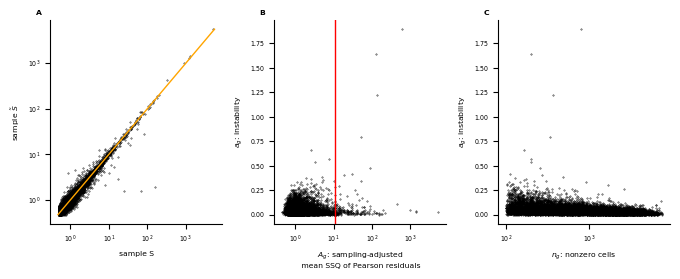

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_stats_Ag = pd.concat ( [ df_nz_cells, df_A_g ], axis=1 ) 
df_stats_Ag = df_stats_Ag.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Ag = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn )  

print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 4' )
print ( '\n', pt_instability_v_nz_cells ) 


  L_g


 df_complementary_stats_Lg

                              0           1
ENSEMBL_ID                                
ENSMUSG00000052305  563.918005  538.091370
ENSMUSG00000069919  435.447142  413.672813
ENSMUSG00000069917  397.902680  387.781072
ENSMUSG00000073940  242.065292  252.862804
ENSMUSG00000013936  103.222378   97.025613
...                        ...         ...
ENSMUSG00000049904    0.537811    0.592265
ENSMUSG00000021763    0.536981    0.695864
ENSMUSG00000097239    0.529520    0.639579
ENSMUSG00000037703    0.524249    1.772005
ENSMUSG00000037455    0.503722    0.476033

[12995 rows x 2 columns]


 genes rank_stat_200:  11.242319816288312


 Table 6

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        19      1       0        0        0         0      0     20
21-50        1     29       0        0        0         0      0     30
51-100       0      0      47   

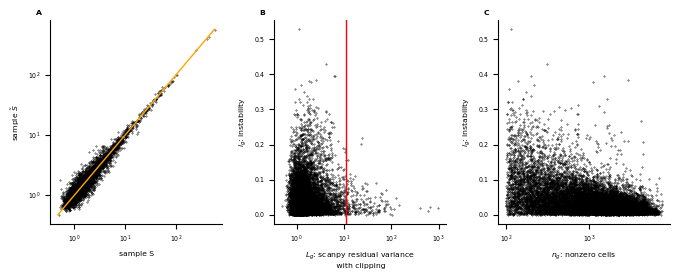

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_stats_Lg = pd.concat ( [ df_nz_cells, df_L_g ], axis=1 ) 
df_stats_Lg = df_stats_Lg.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Lg = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 

print ( '\n\n Table 6' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 7' )
print ( '\n', pt_instability_v_nz_cells ) 


  S_g


 df_complementary_stats_Sg

                             0          1
gene_vector                             
ENSMUSG00000000001   0.643577   0.674521
ENSMUSG00000000028   0.956653   0.911658
ENSMUSG00000000031  36.894753  41.702735
ENSMUSG00000000037   0.261762   0.316140
ENSMUSG00000000056   1.029336   0.930824
...                       ...        ...
ENSMUSG00000116858   0.647649   0.615864
ENSMUSG00000116883   0.742559   0.722968
ENSMUSG00000116895   0.301955   0.365790
ENSMUSG00000116951   1.678848   1.589874
ENSMUSG00000116953   0.498503   0.405890

[12995 rows x 2 columns]


 genes rank_stat_200:  13.991735069511451


 Table 9

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      2       0        0        0         0      0     20
21-50        2     25       3        0        0         0      0     30
51-100       0      3      42        5        0         0 

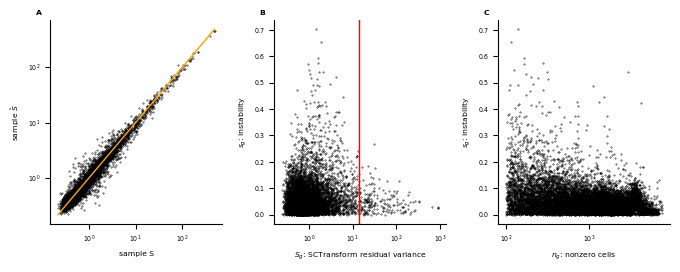

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_stats_Sg = pd.concat ( [ df_nz_cells, df_S_g ], axis=1 ) 
df_stats_Sg = df_stats_Sg.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Sg = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 

print ( '\n\n Table 9' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 10' )
print ( '\n', pt_instability_v_nz_cells ) 

In [10]:
MW_stat, MW_pv = mannwhitneyu( arr_instability_Lg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='less' )   

print ( ' one-sided tests \n ---------------  \n\n null: L_g = A_g,  alternative: L_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )


MW_stat, MW_pv = mannwhitneyu( arr_instability_Sg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='less' )   

print ( '\n\n null: S_g = A_g,  alternative: S_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )

 one-sided tests 
 ---------------  

 null: L_g = A_g,  alternative: L_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  1792947.0      p =  0.0011047255164954536

 scipy.stats.ks_2samp:  
 statistic =  1792947.0      p =  0.002221484589106456


 null: S_g = A_g,  alternative: S_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  2262546.0      p =  5.678986816673302e-50

 scipy.stats.ks_2samp:  
 statistic =  2262546.0      p =  7.692311853792967e-41
